# ICA

This is accompanying practical example of ICA application. For theoretical introduction see [ICA_Theoretical_Basis.pdf](https://github.com/m5imunovic/studious-engine/doc/ICA_Theoretical_Basis.pdf) in the same repo.


In [1]:
# Enable easy (re)imports from local repository
import sys

from pathlib import Path

sys.path.append("../src")

%load_ext autoreload
%autoreload 2

In [2]:
# Import required external dependencies
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

%matplotlib inline

np.random.seed(2023)

In [3]:
# Import local dependencies
from fast_ica import fast_ica_defl

from utils.image_ops import image_to_np_array, mix_images, normalize_image
from utils.path_helpers import get_data_root
from utils.plot_ops import plot_dependency
from utils.stat_ops import center, covariance, whiten_svd

## Import data

We are using the images from the dataset [DigiFace-1M](https://microsoft.github.io/DigiFace1M/) and two sources that were generated randomly, one with Gaussian and one with Poisson distribution.

In [4]:
FOUR_FACES_PATH = get_data_root() / "four_faces" / "grayscale"
image_paths = list(FOUR_FACES_PATH.glob("*.png"))
input_images = [image_to_np_array(image_path) for image_path in image_paths]
input_images_norm = [normalize_image(image) for image in input_images]

N_inputs = len(input_images) # number of input images
n_samples = input_images[0].size # number of pixels in each image

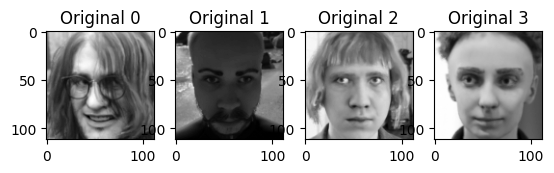

In [5]:
for i in range(len(input_images)):
    plt.subplot(1, N_inputs, i+1), plt.imshow(input_images[i], cmap="gray"), plt.title(f"Original {i}")

In [6]:
# create additional sources
noise_signal = np.random.poisson(size=input_images[0].shape)
gaussian_signal = np.random.normal(loc=0., scale=0.23, size=input_images[0].shape)

# create mixing matrix
A2x2 = np.array([[0.3, 0.55], [0.4, 0.3]])
A3x3 = np.random.rand(3, 3)

In [7]:
# create a sources matrix
S_I = np.array([input_images_norm[0], input_images_norm[3]])
S_II = np.array([gaussian_signal, input_images_norm[1]])
S_III = np.array([noise_signal, input_images_norm[2]])


mixture_I = mix_images(S_I, A2x2)
mixture_II = mix_images(S_II, A2x2)
mixture_III = mix_images(S_III, A2x2)

all_sources = [S_I, S_II, S_III]
all_mixtures = [mixture_I, mixture_II, mixture_III]

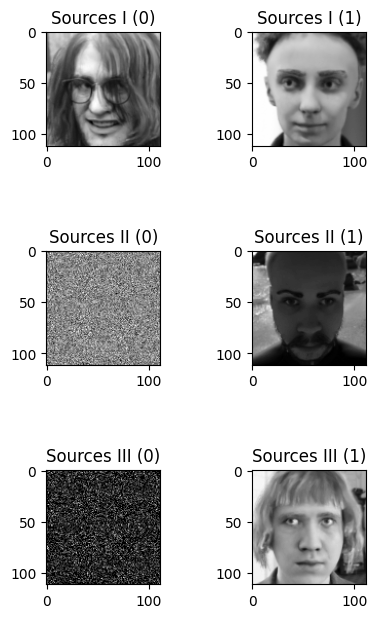

In [8]:
L = len(S_I)
plt.figure(figsize=(4, 14))
plt.subplots_adjust(left=0.1, bottom=0.5, right=0.9, top=0.9, wspace=0.8, hspace=0.8)

for j in range(len(all_sources)):
    for i in range(L):
        plt.subplot(3, L, j*2 + i+1), plt.imshow(all_sources[j][i], cmap="gray"), plt.title(f"Sources {'I'*(j+1)} ({i})")


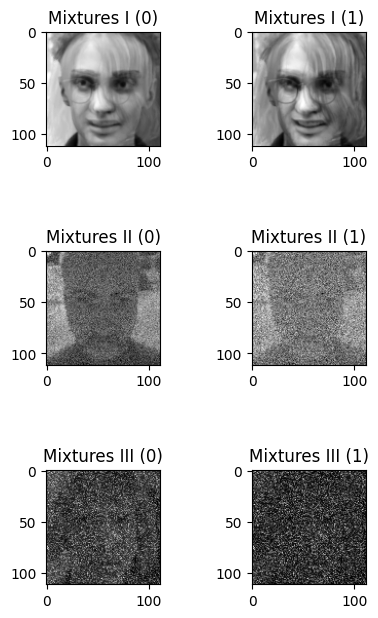

In [9]:
L = len(S_I)
plt.figure(figsize=(4, 14))
plt.subplots_adjust(left=0.1, bottom=0.5, right=0.9, top=0.9, wspace=0.8, hspace=0.8)

for j in range(len(all_sources)):
    for i in range(L):
        plt.subplot(3, L, j*2 + i+1), plt.imshow(all_mixtures[j][i].reshape(input_images[0].shape), cmap="gray"), plt.title(f"Mixtures {'I'*(j+1)} ({i})")

### Reconstruction of sources using custom FastICA implementation

We are first preprocessing the mixture (centering and whitening) and then generating the unmixing matrix in order to reconstruct the original signals.

In [10]:
X_I_centered, mean_X_I = center(mixture_I)
X_II_centered, mean_X_II = center(mixture_II)
X_III_centered, mean_X_III = center(mixture_III)

X_I_whitened = whiten_svd(X_I_centered)
X_II_whitened = whiten_svd(X_II_centered)
X_III_whitened = whiten_svd(X_III_centered)

In [11]:
print("Covariance matrix of whitened mixture I:")
print(np.round(covariance(X_I_whitened)))
print("Covariance matrix of whitened mixture II:")
print(np.round(covariance(X_II_whitened)))
print("Covariance matrix of whitened mixture III:")
print(np.round(covariance(X_II_whitened)))

Covariance matrix of whitened mixture I:
[[ 1. -0.]
 [-0.  1.]]
Covariance matrix of whitened mixture II:
[[1. 0.]
 [0. 1.]]
Covariance matrix of whitened mixture III:
[[1. 0.]
 [0. 1.]]


In [12]:
W_I = fast_ica_defl(X_I_whitened, steps=5000, whiten="svd")
W_II = fast_ica_defl(X_II_whitened, steps=5000, whiten="svd")
W_III = fast_ica_defl(X_III_whitened, steps=5000, whiten="svd")

Returns from optimization loop after 4 steps, reached threshold 1.7367482552765878e-05
Returns from optimization loop after 4 steps, reached threshold 2.436571028285872e-05
Returns from optimization loop after 3 steps, reached threshold 7.590330782447641e-05
Returns from optimization loop after 4 steps, reached threshold 3.8733994510598e-05
Returns from optimization loop after 67 steps, reached threshold 1.9287689232094785e-05
Returns from optimization loop after 63 steps, reached threshold 6.054138251387897e-06


In [13]:
reconstructed_I = W_I.dot(X_I_whitened) - mean_X_I
reconstructed_II = W_II.dot(X_II_whitened) - mean_X_II
reconstructed_III = W_III.dot(X_III_whitened) - mean_X_III

all_reconstructed = [reconstructed_I, reconstructed_II, reconstructed_III]

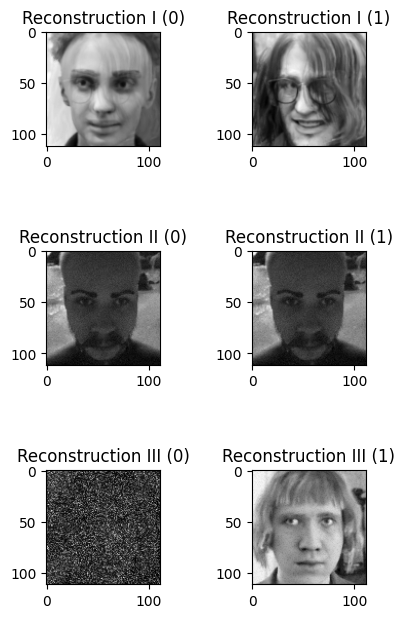

In [14]:
L = len(S_I)
plt.figure(figsize=(4, 14))
plt.subplots_adjust(left=0.1, bottom=0.5, right=0.9, top=0.9, wspace=0.8, hspace=0.8)

for j in range(len(all_sources)):
    for i in range(L):
        plt.subplot(3, L, j*2 + i+1), plt.imshow(all_reconstructed[j][i].reshape(input_images[0].shape), cmap="gray"), plt.title(f"Reconstruction {'I'*(j+1)} ({i})")

### Visualize dependency relations

Here we visualize the dependency relations between the distributions of the sources, their mixtures and in the end, 
the reconstructed signals. We notice that the mixture components are more dependent than sources and reconstructed signals (with exception of the mixture with Gaussian)

In [15]:
dependency_titles = ["Image vs Image", "Image vs Gaussian", "Image vs Poission"]

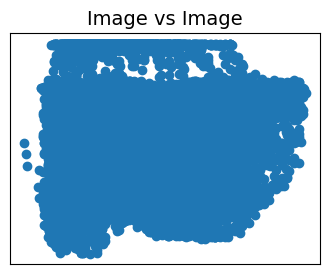

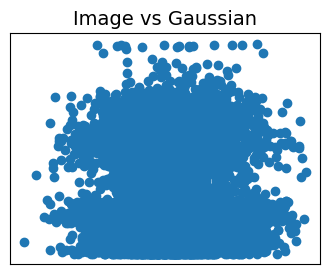

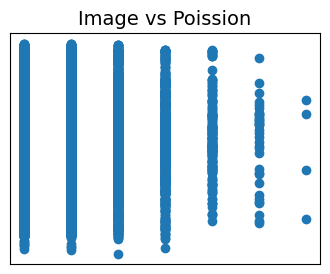

In [16]:
plot_dependency(all_sources, titles=dependency_titles, normalize=False)

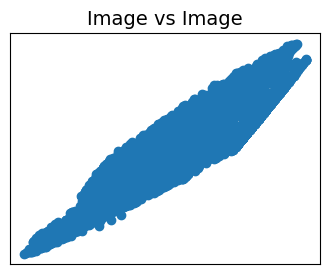

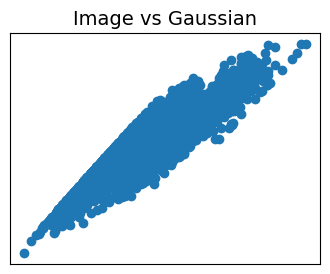

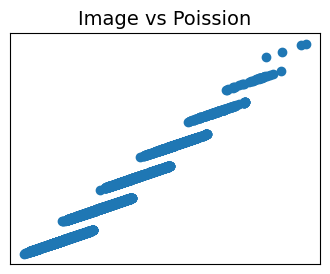

In [17]:
plot_dependency(all_mixtures, titles=dependency_titles, normalize=False)

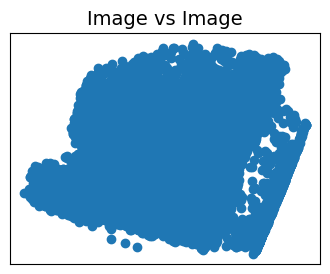

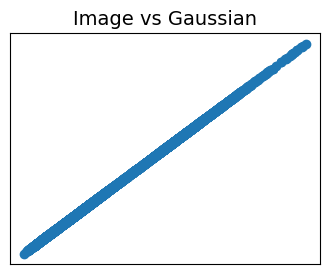

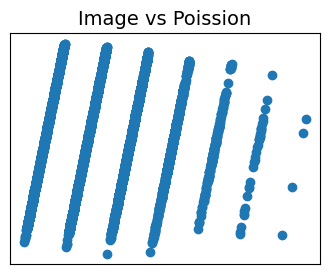

In [18]:
plot_dependency(all_reconstructed, titles=dependency_titles, normalize=False)